In [1]:
import os,glob,copy
import numpy as np
import pandas as pd
import glob
import pyslha
import time
from numpy.linalg import norm
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import pickle
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

delphesDir = os.path.abspath("../MG5/Delphes")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

Welcome to JupyROOT 6.26/04


True

In [2]:

# # Load events, apply cuts and store relevant info

# ## Cuts
## Trigger efficiency
triggerEff = 0.9 # Applied to the event weight

## jets
pTj1min = 100.
pTjmin = 20.
etamax = 2.4
## MET
minMET = 250.
## Electrons
pTmin_el = 10.
etamax_el = 2.5
nMax_el = 0
## Photons
pTmin_a = 15.
etamax_a = 2.5
nMax_a = 0
## Muons
pTmin_mu = 10.
etamax_mu = 2.4
nMax_mu = 0
## Tau jets
nMax_tau = 0
etatau_max = 2.3
pTtau_min = 18.0
## b jets
nMax_b = 0
etab_max = 2.4
pTb_min = 20.0

def passVetoJets2018(jets):
    """
    Calorimeter mitigation failure I for the 2018
    data set.

    :param jets: List of Jet objects

    :return: True if event should be accepted, False otherwise.
    """

    for jet in jets:
        if jet.PT < 30.0:
            continue
        if jet.Phi < -1.57 or jet.Phi > -0.87:
            continue
        if jet.Eta < -3.0 or jet.Eta > -1.3:
            continue
        return False
    return True

def passVetoPtMiss2018(met):
    """
    Calorimeter mitigation failure II for the 2018
    data set.

    :param met: MET object

    :return: True if event should be accepted, False otherwise.
    """        

    if met.MET > 470.:
        return True
    if met.Phi < -1.62 or met.Phi > -0.62:
        return True
    return False


with open('../AuxInfo/CMS-EXO-20-004-data/deepAK8effs.pcl', 'rb') as ff:
    fInt = pickle.load(ff)
    
def deepAK8effs(pT,pid=23,dt=2017,wpoint='tight'):
    
    pid = abs(pid) # Use absolute PID value
    dt = max(dt,2017) # Use 2017 for 2016 dataset
    f = fInt[(abs(pid),dt,wpoint)]
    eff = min(1.0,max(0.,f(pT)))
    eff = float(eff)    
    return eff

luminosities = {2016 : 36.0, 2017 : 41.5, 2018: 59.7}
lumTot = sum(luminosities.values())
yields = {ds : [] for ds in luminosities}
metAll = {ds : [] for ds in luminosities}
totalweightPB = 0.0
# Keep track of yields for each dataset
cutFlowAll = {ds : 
                {'Fullsample' : 0.0,
                'Triggeremulation' : 0.0,
                '$p_{T}^{miss}>250$GeV' : 0.0, 
                'Electronveto' : 0.0,
                'Muonveto' : 0.0, 
                'Tauveto' : 0.0, 
                'Bjetveto' : 0.0, 
                'Photonveto' : 0.0,
                '$\Delta \phi (jet,p_{T}^{miss})>0.5$ rad' : 0.0,
                'LeadingAK4jet$p_{T}>100$GeV' : 0.0, 
                'LeadingAK4jet$\eta<2.4$' : 0.0,            
                'HCALmitigation(jets)' : 0.0,
                'HCALmitigation($\phi^{miss}$)' : 0.0}
            for ds in luminosities}


In [3]:
inputFile = '../DMSimp_axial_0jw_match/Events/run_01/axial_2000_1_delphes_events.root'

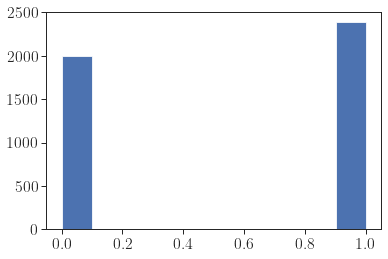

In [12]:
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
nevts = tree.GetEntries()

nVs = []
for ievt in range(nevts):    

    tree.GetEntry(ievt)  
    vbosons = tree.VBosons
    nVs.append(vbosons.GetEntries())
plt.hist(nVs,bins=10)
plt.show()

In [4]:
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
nevts = tree.GetEntries()

allVs = []
drJV = 0.2
allJVs = []
for ievt in range(nevts):    

    tree.GetEntry(ievt)  

    jets = tree.Jet
    jetsAK8 = tree.FatJet
    weightPB = tree.Weight.At(1).Weight

    missingET = tree.MissingET.At(0)
    electrons = tree.Electron
    muons = tree.Muon
    photons = tree.Photon
    vbosons = tree.VBosons
    particles = tree.Particle
    
    vList = []
    for iv in range(vbosons.GetEntries()):
        v = copy.deepcopy(vbosons.At(iv))
#         if v.PT < 200.0:
#             continue            
        v.matched = False
        vList.append(v)
    vList = sorted(vList, key = lambda v: v.PT, reverse=True)
    
    if not vList:
        continue
    
    # Fat jets
    jetAK8List = []
    for ijet in range(jetsAK8.GetEntries()):
        jet = copy.deepcopy(jetsAK8.At(ijet))
        if jet.PT > 250.0 and abs(jet.Eta) < 2.4:
            jet.VTag = False
            jetAK8List.append(jet)
    jetAK8List = sorted(jetAK8List, key = lambda j: j.PT, reverse=True)   
    
    if not jetAK8List:
        continue
    
    for j in jetAK8List:
        drs = [np.sqrt((j.Eta-v.Eta)**2 + (j.Phi-v.Phi)**2) for v in vList if not v.matched]
        if not drs:
            break # All Vs have already been matched
        drmin = min(drs)
        if drmin > drJV:
            continue
        iv = drs.index(drmin)
        v = vList[iv]
        j.VTag = v.PID
        j.drJV = drmin
        v.matched = True
                
    vjetList = [j for j in jetAK8List if j.VTag]
    jetList = [j for j in jetAK8List if not j.VTag]
#     vList = [v for v in vList if v.matched]
    
    allVs.append(vList)
    allJVs.append(vjetList)


In [5]:
nVs = [len(vList) for vList in allVs]
nVms = [len([v for v in vList if v.matched]) for vList in allVs]
nJs = [len(vjetList) for vjetList in allJVs]

In [6]:
drs = []
vPIDs = set([])
for vjetList in allJVs:
    drs += [j.drJV for j in vjetList]
    for j in vjetList:
        vPIDs.add(j.VTag)

In [7]:
print(vPIDs)

{24, -24}


In [8]:
pTVs = []
for vList in allVs:
    pTVs += [v.PT for v in vList]

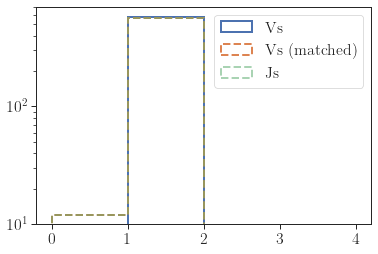

In [9]:
plt.hist(nVs,bins=[0,1,2,3,4],label='Vs',histtype='step',linewidth=2)
plt.hist(nVms,bins=[0,1,2,3,4],label='Vs (matched)',histtype='step',linewidth=2,linestyle='--')
b = plt.hist(nJs,bins=[0,1,2,3,4],label='Js',histtype='step',linewidth=2,linestyle='--',alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()

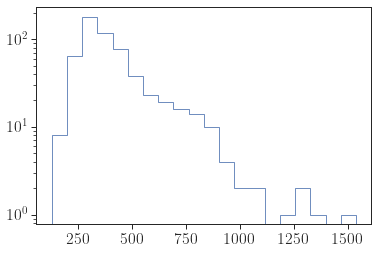

In [10]:
plt.hist(pTVs,bins=20,histtype='step')
plt.yscale('log')
# plt.xlim(0,100)
plt.show()

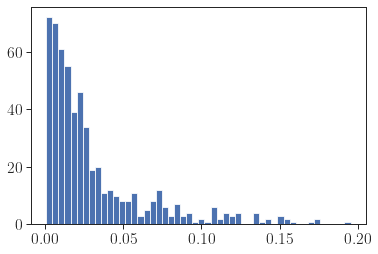

In [11]:
plt.hist(drs,bins=50)
plt.show()